## ResNet

在之前 VGG 的架構中，通過加深神經網路之後，能夠得到比 AlexNet 更高準確度。  
基於同樣道理，如果我們繼續加深網路進行訓練，卻只會讓訓練變得差勁，其因可歸咎於網路過大導致數值不夠穩定，因此無法有效收斂。

導入 Residual Block (殘差模塊)，其思路為加入一條捷徑，藉由跨層傳遞，以此來傳遞特徵資訊，  
如此一來，即便加深網路也可以確保資訊不會因為過多卷積運算而消失，反而可以融合更多特徵細節，使資訊更有效傳遞，  
另一方面，也可以避免因為神經網路太深而導致梯度消失 (Vanishing gradient)，使模型能成功進行訓練。

### Reference

[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). [Deep residual learning for image recognition.](https://arxiv.org/abs/1512.03385) In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

### 引入相關python模組

In [1]:
from mycnn import ResNet18, ResNet50, ResNet101
from mycnn import utils
from mycnn import data
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 自動下載貓狗資料集

從 Microsoft Download Center 下載 Kaggle Cats and Dogs Dataset  
會自動在工作路徑底下建立資料夾，並建立相關的資料集檔案結構  
也會檢查路徑底下是否已經有建立完成檔案，避免重複下載及建立

In [2]:
data.cats_vs_dogs_from_MSCenter('./datasets')

Already download zip file.
Already make dataset.


### 使用Keras API來建立Dataset實例

利用Keras API中的`preprocessing`模組的`image_dataset_from_directory`  
用此函數來建立貓狗的資料集，此函數將會回傳`tf.data.Dataset`的實例  
接著使用`map`函式來重新縮放(正規化)資料區間至 [0, 1]

```
tf.keras.preprocessing.image_dataset_from_directory

參數名稱            型態    說明
directory        : str   : 資料路徑 (子資料夾為類別)
image_size       : tuple : 影像大小
batch_size       : int   : 批次大小
label_mode       : str   : 標記模式 "categorical" (註:其他模式需要修改loss函數)
validation_split : float : 分離驗證集的比例
subset           : str   : 選擇訓練集 "training"、驗證集 "validation"
seed             : int   : 亂數種子
```

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './datasets/DogsVsCats/train',
    image_size=(224,224),
    batch_size=50,
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=10
)
train_file_paths = train_dataset.file_paths
train_dataset = train_dataset.map(lambda x, y: (x/255., y))


valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './datasets/DogsVsCats/train',
    image_size=(224,224),
    batch_size=50,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
valid_file_paths = valid_dataset.file_paths
valid_dataset = valid_dataset.map(lambda x, y: (x/255., y))

Found 24000 files belonging to 2 classes.
Using 19200 files for training.
Found 24000 files belonging to 2 classes.
Using 4800 files for validation.


### 檢查原始資料

./datasets/DogsVsCats/train\Dogs\6534.jpg


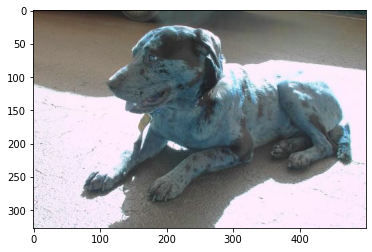

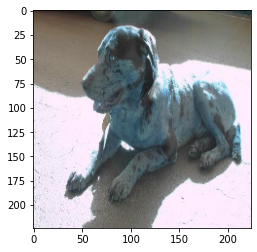

In [4]:
idx = 0
file_path = valid_file_paths[idx]
print(file_path)
image = cv2.imread(file_path)
plt.imshow(image)
plt.show()

resized_image = cv2.resize(image, (224,224))
plt.imshow(resized_image)
plt.show()

### 載入模型

```
參數名稱       型態    說明
input_shape : tuple : 輸入影像形狀
classes_num : int   : 輸出類別數量
```

In [5]:
cnn = ResNet50(classes_num=2)
cnn.summary()

Model: "ResNet50"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
image (InputLayer)                                    [(None, 224, 224, 3)]                           0                 
________________________________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)                             (None, 230, 230, 3)                             0                 
________________________________________________________________________________________________________________________
conv1_conv (Conv2D)                                   (None, 112, 112, 64)                            9472              
________________________________________________________________________________________________________________________
conv1_bn (Batc

### 配置訓練參數

```
參數名稱      型態                         說明
logdir     : str                        : 儲存路徑
epochs     : int                        : 訓練次數
batch_size : int                        : 批次大小 (註:此設定需與image_dataset_from_directory的批次大小一致)
optimizer  : str or tf.keras.optimizers : 優化函數
loss       : str or tf.keras.loss       : 損失函數
metrics    : list                       : 評估函數清單
```

In [6]:
cnn.setup_training(
    'log_resnet',
    epochs=30,
    batch_size=50,  # batch size depend on ImageGenerator
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn.add_callback(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, patience=5,
        min_lr=0.00001,
        verbose=1
    )
)

[Info] Create new the directory for training log !!!!!
******************************
Training new model...
******************************
checkpoint_path : log_resnet\weights
best_checkpoint : log_resnet\weights.h5
epochs          : 30
initial_epoch   : 0
batch_size      : 50
optimizer       : {'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
loss            : categorical_crossentropy
metrics         : ['accuracy']


### 開始訓練

輸入參數分別為訓練資料集、驗證資料集的實例

In [7]:
cnn.train_dataset(train_dataset, valid_dataset)

Epoch 1/30
384/384 [==============================] - 198s 493ms/step - loss: 0.9505 - accuracy: 0.6002 - val_loss: 4.3391 - val_accuracy: 0.5213

Epoch 00001: val_loss improved from inf to 4.33913, saving model to log_resnet\weights.h5
Epoch 2/30
384/384 [==============================] - 189s 490ms/step - loss: 0.6173 - accuracy: 0.6742 - val_loss: 0.8737 - val_accuracy: 0.5496

Epoch 00002: val_loss improved from 4.33913 to 0.87366, saving model to log_resnet\weights.h5
Epoch 3/30
384/384 [==============================] - 184s 477ms/step - loss: 0.5600 - accuracy: 0.7208 - val_loss: 4.5662 - val_accuracy: 0.4563

Epoch 00003: val_loss did not improve from 0.87366
Epoch 4/30
384/384 [==============================] - 181s 469ms/step - loss: 0.5190 - accuracy: 0.7566 - val_loss: 0.7188 - val_accuracy: 0.6190

Epoch 00004: val_loss improved from 0.87366 to 0.71879, saving model to log_resnet\weights.h5
Epoch 5/30
384/384 [==============================] - 181s 469ms/step - loss: 0.454

### 繪製訓練過程曲線

可以用來確認權重是否有收斂的趨勢、檢查是否有過擬合狀況

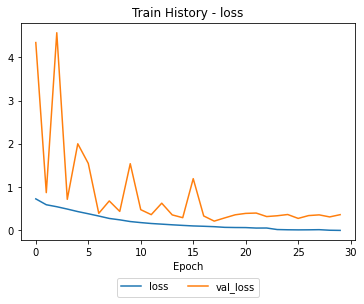

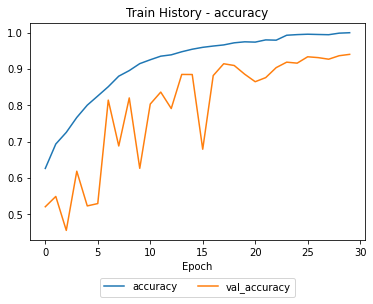

In [8]:
cnn.show_history(["loss", "accuracy"])

### 使用測試資料來確認模型對於新資料的效能

In [9]:
cnn.eval_dataset(valid_dataset)

96/96 [==============================] - 17s 175ms/step - loss: 0.3646 - accuracy: 0.9402


[0.36461392045021057, 0.9402083158493042]

### 使用confusion matrix來更進一步確認分類性能

- 預測測試資料的分數 (基於softmax函數計算機率分布)
- 使用`argmax`將分數轉成類別ID
- 輸出分類報告 (印出confusion matrix、分類報告；輸出完整報表)
- 繪製confusion matrix，分為recall、precision

> Note:  
recall: 召回率，在所有GT中，真正預測出TP的指標  
precision: 精確率，在所有預測結果中，真正為TP的指標  
(GT: 真實情況；TP: 正樣本)

Found 24000 files belonging to 2 classes.
Using 4800 files for validation.


100%|██████████| 4800/4800 [00:00<00:00, 320257.37it/s]


[[2195  200]
 [  87 2318]] 

              precision    recall  f1-score   support

        Cats       0.96      0.92      0.94      2395
        Dogs       0.92      0.96      0.94      2405

    accuracy                           0.94      4800
   macro avg       0.94      0.94      0.94      4800
weighted avg       0.94      0.94      0.94      4800
 



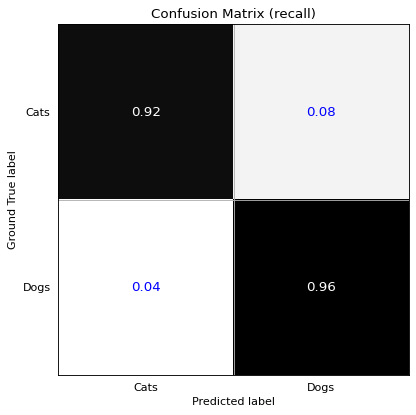

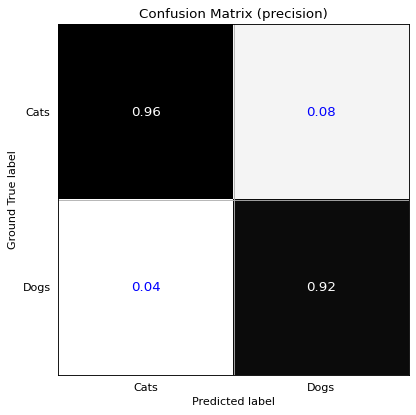

In [10]:
pred_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './datasets/DogsVsCats/train',
    image_size=(224,224),
    batch_size=20,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
pred_dataset = pred_dataset.map(lambda x, y: (x/255., y))

pr_score = None
pr_label = None
gt_label = None
for ind, batch_set in enumerate(pred_dataset):
    batch_im, batch_gt = batch_set
    batch_pr = cnn.pred(batch_im.numpy())
    if ind == 0:
        pr_score = batch_pr
        pr_label = batch_pr.argmax(axis=-1)
        gt_label = batch_gt.numpy().argmax(axis=-1)
    else:
        pr_score = np.concatenate([pr_score, batch_pr])
        pr_label = np.concatenate([pr_label, batch_pr.argmax(axis=-1)])
        gt_label = np.concatenate([gt_label, batch_gt.numpy().argmax(axis=-1)])

target_names = ["Cats", "Dogs"]

report = utils.export_classification_report(
    gt_label, pr_label, pr_score,
    target_names=target_names,
    logpath=cnn.logdir
)

cm = report["confusion_matrix"]
cm_precision = cm/cm.sum(axis=0)
cm_recall = cm/cm.sum(axis=1)
utils.plot_confusion_matrix(cm_recall, target_names, cnn.logdir, title='Confusion Matrix (recall)')
utils.plot_confusion_matrix(cm_precision, target_names, cnn.logdir, title='Confusion Matrix (precision)')

### 預測單筆資料

./datasets/DogsVsCats/train\Dogs\6534.jpg


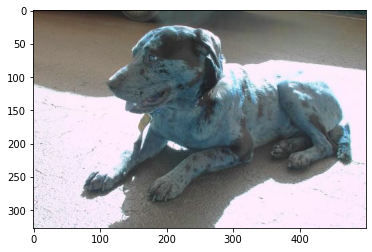

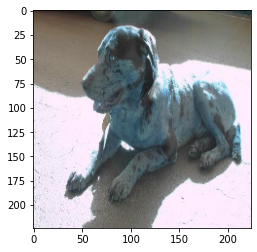

(1, 224, 224, 3, 1)

[Info] Use `tf.keras.Model` method predict

Score:
[0. 1.]
Label: 1


In [11]:
idx = 0

file_path = valid_file_paths[idx]
print(file_path)
image = cv2.imread(file_path)
resized_image = cv2.resize(image, (224,224))
plt.imshow(resized_image)
plt.show()

batch_one_image = np.expand_dims(resized_image, axis=0)
print(batch_one_image.shape)

pr_sc = cnn.predict(batch_one_image/255.)
pr_lb = pr_sc.argmax(axis=-1)
print("Score:")
print(pr_sc[0])
print("Label:", pr_lb[0])